# Reconecimento de fala 

Notebook baseado neste artigo [aqui.](https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/)

O objetivo é reconhecer 4 comandos básicos (yes, no, on, off) utilizando uma rede neural convolucional 1D. 

Vamos começar obtendo um arquivo simplificado de comandos de voz (no formato wav, organizados em pastas, que é disponibilizado por Google (parte dos dados para teste no ambiente TensorFlow para implementação de modelos *Deep Learning*). O arquivo contém muito mais comandos do que precisamos. 
## Obtendo e descompactando os arquivos de audio

In [ ]:
#DADOS='data'
DADOS='data2'
import urllib.request
#urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=13_x2g79Mx-aXWaYPrprXjkhZaEwv1lJh', 'data.zip')
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1a8u-PFsEcz5eq5LCfA2X1ymRy6DYJPo5','data2.zip')

('data2.zip', <http.client.HTTPMessage at 0x7fb648e82588>)

In [ ]:
!unzip  -n $DADOS".zip"

Archive:  data2.zip


## Importando as bibliotecas necessárias

In [ ]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

**Explorando e visualizando os dados**

*Sinal de audio no domínio do tempo*. Experimente visualizar exemplos de audio de cada uma das classes.

OBS: Caso mude o dataset para data2 na primeira célula deste notebook, você precisará escolher outros exemplos de audio para exibir aqui. Utilize comandos como %ls para listar o conteúdo da pasta contendo o novo dataset descompactado.

frac 1.0


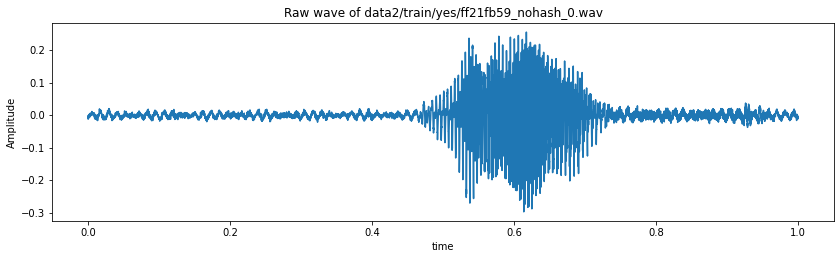

In [ ]:
train_audio_path = DADOS+'/train/'
#yes_files = train_audio_path+'yes'
#%ls $yes_files
filename=train_audio_path+'yes/ff21fb59_nohash_0.wav'
#filename = train_audio_path+'off/0ff728b5_nohash_2.wav'
#filename = train_audio_path+'yes/fe291fa9_nohash_0.wav'
samples, sample_rate = librosa.load(filename, sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' +filename)
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
print('frac',sample_rate/len(samples))
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

*Visualizando o spectograma do sinal*

A função stft (short-time Fourier transform) representa um sinal no domínio da frequência calculando transformações discretas de Fourier (DFT) em pequenas janelas sobrepostas.


[[ 1.6662845e-01-0.0000000e+00j  1.3073623e-02-0.0000000e+00j
  -1.4701369e-01-0.0000000e+00j ... -7.8746133e-02-0.0000000e+00j
  -3.9044496e-01-0.0000000e+00j -4.5473775e-01-0.0000000e+00j]
 [-1.6581134e-01-4.4858865e-18j  1.0459950e-02-1.5743794e-01j
   8.6793609e-02-4.8109242e-03j ...  1.2493546e-01-2.3700322e-01j
   2.2413658e-01-6.3482322e-02j  2.2500238e-01+3.8991515e-03j]
 [ 4.8424739e-02+6.3175105e-17j  3.9957515e-03+1.3453673e-01j
   2.1226052e-02-1.3546124e-01j ... -1.3372500e-01-5.7418183e-03j
  -3.6827184e-02+4.2314015e-02j  1.7987663e-02-2.7947849e-02j]
 ...
 [ 2.7351130e-03-1.6120731e-17j -1.4484107e-03+2.8323344e-05j
   2.0912968e-04-6.1511659e-05j ... -9.5210818e-04+3.6398182e-03j
   3.0528656e-05-2.6714927e-04j  8.3665922e-04+3.8318126e-04j]
 [-2.9439551e-03+1.5219488e-17j -2.2403304e-04+1.2941675e-03j
  -3.4390073e-04+1.5648366e-04j ...  5.3996281e-03-3.3327197e-03j
   6.2861544e-04-2.3276987e-03j -1.0303321e-03-6.6389848e-04j]
 [ 3.1530559e-03-0.0000000e+00j  1.85620

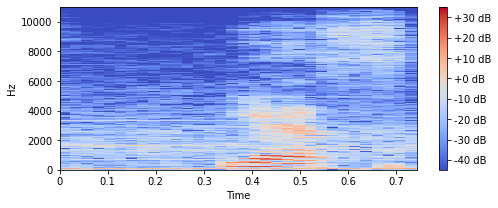

In [ ]:
import librosa.display
X = librosa.stft(samples)
print(X)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(8, 3))
librosa.display.specshow(Xdb, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

**Taxa de amostragem**

Vejamos qual é a taxa de amostragem utilizada na aquisição dos audios. Como fica a audição de um sinal se alterarmos a taxa de amostragem original para outra,  no método de playback do audio?

In [ ]:
print(sample_rate)

16000


In [ ]:
ipd.Audio(samples, rate=sample_rate, autoplay=True)

In [ ]:
ipd.Audio(samples, rate=sample_rate/4,  autoplay=True)

In [ ]:
ipd.Audio(samples, rate=sample_rate*2,  autoplay=True)

**Reamostragem**
Pelo exposto, podemos entender que a taxa de amostragem do sinal é de 16000 hz. Vamos reamostrá-lo para 8000 hz, pois a maioria das frequências relacionadas à fala está presente em no máximo 8000z. Você notou alguma mudança na forma como o audio soa? Mudou a qualidade?

In [ ]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000, autoplay=True)

Vamos agora obter o número de gravações para cada comando de voz:

In [ ]:
labels=os.listdir(train_audio_path)
print(labels)

['yes', 'off', 'no', 'on']


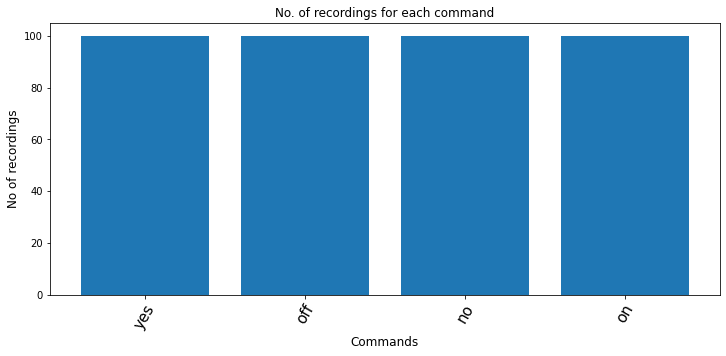

In [ ]:
#computa o número de gravações para cada comando e desenha um gráfico de barra
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(12,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [ ]:
#labels=["off", "yes", "on", "no"]
print(labels)

['yes', 'off', 'no', 'on']


**Duração das gravações**

Vamos agora computar as distribuições de duração de todas as gravações. O que dá para concluir a partir do gráfico?

(array([  1.,   0.,   1.,   3.,   4.,   4.,   7.,   5.,  10., 365.]),
 array([0.4644375 , 0.51799375, 0.57155   , 0.62510625, 0.6786625 ,
        0.73221875, 0.785775  , 0.83933125, 0.8928875 , 0.94644375,
        1.        ]),
 <a list of 10 Patch objects>)

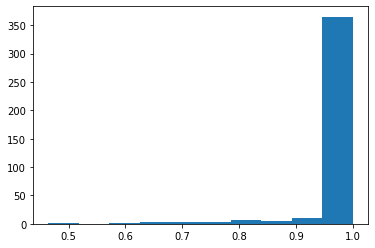

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

**Pré-processando os arquios de audio**

Na parte de exploração de dados anterior, vimos que a duração de algumas gravações é inferior a 1 segundo e a taxa de amostragem é muito alta. Então, vamos ler os sinais de áudio e usar as etapas de pré-processamento apresentadas a seguir,  para lidar com isso.

Aqui estão os dois passos que seguiremos:

* Reamostragem
* Remoção de comandos com sinal mais curto do que 1 segundo

Vamos definir essas etapas de pré-processamento no snippet de código abaixo:

In [ ]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 4000)
        if(len(samples)== 4000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
off
no
on


In [ ]:
print(len(all_wave))
#print(all_wave)
print(all_label.count('no'))
print(all_label.count('yes'))
print(all_label.count('on'))
print(all_label.count('off'))

354
87
93
89
85


Convertendo os rótulos de saída (strings) para inteiros.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(all_label)
print(y)

['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off', 'off'

Agora, converteremos os rótulos codificados com números inteiros em um vetor do tipo one-hot-encoding (ou winner-takes-all), pois é um problema de classificação múltipla e é esse o tipo de entrada esperada por modelos de redes neurais em geral. Neste exemplo, utilizaremos uma rede neural convolucional com convoluções 1D.


In [ ]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
print(y)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


Remodele a matriz 2D para 3D, pois a entrada para o conv1d deve ser uma matriz 3D:


In [ ]:
print(all_wave)
all_wave = np.array(all_wave).reshape(-1,4000,1)
print(all_wave.shape)
print(all_wave)


[array([0.00798294, 0.02244443, 0.02843334, ..., 0.03028125, 0.02229736,
       0.0172369 ], dtype=float32), array([ 6.0292105e-06, -4.0965922e-05, -1.2103301e-05, ...,
       -3.7387060e-06,  7.0670253e-06,  4.3541113e-05], dtype=float32), array([-0.00306545, -0.00255798, -0.00032414, ...,  0.00208129,
        0.00335378,  0.00496577], dtype=float32), array([ 0.00059231,  0.00127999,  0.00164052, ..., -0.0014198 ,
       -0.00164087, -0.00128176], dtype=float32), array([0.00690541, 0.024267  , 0.02964453, ..., 0.04232294, 0.04343956,
       0.01360043], dtype=float32), array([-2.0884928e-04,  6.5104490e-05,  6.6012779e-04, ...,
       -8.1728247e-04, -7.4824662e-04, -7.6375768e-04], dtype=float32), array([ 0.00499435,  0.01075239,  0.01156321, ..., -0.00734156,
       -0.00768946, -0.00995742], dtype=float32), array([0.000825  , 0.00107421, 0.00238646, ..., 0.00040993, 0.00168805,
       0.00159357], dtype=float32), array([ 0.00031299,  0.00066348,  0.00032945, ..., -0.00030426,
     

**Dividir os dados em treinamento e validação**

Treinaremos o modelo em 80% dos dados e validaremos com os 20% restantes:

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [ ]:
print(len(x_tr))
print(len(x_val))

283
71


**Arquitetura de modelo para este problema**

Vamos construir o modelo que converte de fala para texto usando camadas conv1d. Como já mencionado, Conv1d é uma camada de rede neural convolucional que realiza a convolução em apenas uma dimensão.

**Construção do Modelo de Classificação**

Vamos utilizar a interface funcional do Keras para este propósito. O modelo está ilustrado na figura abaixo e o código vem logo após. 
![alt text](https://drive.google.com/uc?export=view&id=16Lsafs24Hqq9Jp_OjBmvpi9wWdW7XvBg)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(4000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1329, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1329, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1319, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 439, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 439, 16)           0   

Definimos a função de perda como entropia cruzada categórica, pois é um problema de multi-classificação:




In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

 Interromperemos o treinamento da rede neural no momento certo (parada por validação) e salvaremos o melhor modelo após cada época:

In [ ]:
%rm -rf models
%mkdir models

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint('./models/best_model.hdf5', monitor='val_loss', mode='auto', verbose=1,save_best_only=True)

Vamos treinar o modelo em um tamanho de lote (batch size) 32 e avaliaremos o seu desempenho no conjunto de validação:


In [ ]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 283 samples, validate on 71 samples
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 1.3882 - accuracy: 0.2580 - val_loss: 1.3872 - val_accuracy: 0.2817

Epoch 00001: val_loss improved from inf to 1.38725, saving model to ./models/best_model.hdf5
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 1.3707 - accuracy: 0.3039 - val_loss: 1.3857 - val_accuracy: 0.3239

Epoch 00002: val_loss improved from 1.38725 to 1.38572, saving model to ./models/best_model.hdf5
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 1.3565 - accuracy: 0.3463 - val_loss: 1.3848 - val_accuracy: 0.3803

Epoch 00003: val_loss improved from 1.38572 to 1.38477, saving model to ./models/best_model.hdf5
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 1.3501 - accuracy: 0.3922 - val_loss: 1.3869 - val_accuracy: 0.3803

Epoch 00004: val_loss did not improve from 1.38477
Epoch 5/100
283/283 [====================

**Curva de Aprendizagem**

Avaliaremos a seguir a evolução das curvas de erro de treinamento e de validação (test) ao longo das várias épocas de treinamento. 

In [ ]:
!date
%ls -l models

Sun May 24 01:22:57 UTC 2020
total 9336
-rw-r--r-- 1 root root 9557976 May 24 01:22 best_model.hdf5


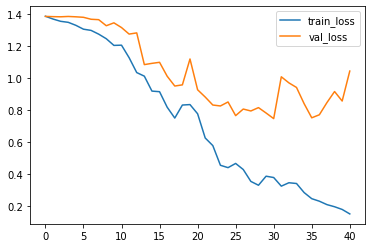

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.legend()
pyplot.show()

**Carregando o melhor modelo para a memória**

In [ ]:
from keras.models import load_model
model=load_model('./models/best_model.hdf5')

Definindo uma função que prediz o texto (classe) para um dado comando de audio:

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,4000,1))
    index=np.argmax(prob[0])
    return classes[index]

Hora da previsão! Faremos previsões nos dados de validação. Um sinal de audio de validação é sorteado aleatoriamente  a cada chamada.

In [ ]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio de entrada:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=4000, autoplay=True)

Audio de entrada: yes


In [ ]:
print("Classe predita:",predict(samples))

Classe predita: yes


Calculando a matriz de confusão e as estatísticas de classificação no conjunto de teste


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_val)
y_pred_int = y_pred.argmax(axis=1)
y_test_int = y_val.argmax(axis=1)
print(confusion_matrix(y_test_int, y_pred_int))
print(classification_report(y_test_int, y_pred_int))


[[16  0  1  0]
 [ 1 12  2  2]
 [ 0  2 15  1]
 [ 4  0  0 15]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        17
           1       0.86      0.71      0.77        17
           2       0.83      0.83      0.83        18
           3       0.83      0.79      0.81        19

    accuracy                           0.82        71
   macro avg       0.82      0.82      0.82        71
weighted avg       0.82      0.82      0.82        71



A melhor parte ainda está por vir! Temos aqui um script que solicita que um usuário grave comandos de voz.
Experimente seus próprios comandos de voz e teste-o no modelo

In [ ]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'

In [ ]:
record(sec=1.2)

<IPython.core.display.Javascript object>

'audio.wav'

Vamos agora ler o arquivo de áudio contendo o comando de voz salvo e, em seguida, convertê-lo em texto usando a rede neural treinada nas etapas anteriores. 


In [ ]:
os.listdir('.')

['.config',
 'data2.zip',
 'data.zip',
 'data2',
 'data',
 'models',
 'audio.wav',
 'sample_data']

In [ ]:
filepath='./'

In [ ]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'audio.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 4000)
ipd.Audio(samples,rate=4000, autoplay=True)              

In [ ]:
#converting voice commands to text
predict(samples[:4000])

'yes'

Parabéns! Você acabou de criar seu próprio modelo de conversão de sinais de fala para texto!



## Agora é a sua vez

1. Altere o nome do arquivo de dados (no início deste notebook) de 'data' para 'data2' e veja o que muda nos resultados. Mantenha o arquivo data2 para o restante dos itens abaixo. Melhorou? Piorou? Tente explicar a razão do resultado ter mudado.
2. Qual o efeito no resultado final de classificação se você reduzir a taxa de amostragem para 4kHz?

## Atividade Bônus
1. Experimente reduzir pela metade a quantidade de filtros convolucionais de todas as camadas da arquitetura neural e avalie o efeito no treinamento e avaliação do modelo na taxa original de 8kHz. Apresente uma discussão dos novos resultados comparativamente aos anteriores.

Resposta 1: Melhorou. Podemos observar por meio da matriz de confusão que obtivemos mais acertos percentualmente usando o data2. Essa melhoria pode ser explicada pelo conjunto de treinamento no data2 ser maior que no data, fazendo com que tenhamos uma rede mais coerente e um erro de treinamento ligeiramente menor que erro de teste.

Resposta 2: Após rodar algumas vezes com 8kHz e 4kHz, verifiquei que com 4kHz geralmente obtém uma acurácia melhor do que 8hz. Mas não percebi uma diferença tão significativa, pois em algumas vezes com 8kHz saiu melhor, ou bem próximo.
